# Imports


In [ ]:
# System and OS utilities
import os
from collections import defaultdict
from google.colab import drive

# Data manipulation and processing
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import (
    ResNet50, EfficientNetB0, InceptionV3, InceptionResNetV2, DenseNet121
)
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M


# Scikit-learn for data preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Image processing
from PIL import Image

# Utility libraries
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
drive.mount('/content/drive')

# Load the images
data_dir = '/content/drive/MyDrive/HHD_AgeSplit'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load the CSV file
csv_dir = os.path.join(data_dir, 'NewAgeSplit.csv')
labels_data = pd.read_csv(csv_dir)

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 128

# Training


## Loading Images and Preprocessing


In [ ]:
def calculate_resized_dimensions(height, width, patch_size=400, stride=200, standard_size=800):
    """
    Calculates resized dimensions to maintain aspect ratio, be compatible with patching, and close to a standard size.

    Args:
        height (int): Original height of the image.
        width (int): Original width of the image.
        patch_size (int): Size of each patch (default 400).
        stride (int): Stride for patching (default 200).
        standard_size (int): Target standard size for the smaller dimension.

    Returns:
        tuple: Resized height and width.
    """
    aspect_ratio = width / height

    # Scale dimensions such that the smaller side matches the standard size
    if height < width:
        new_height = standard_size
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = standard_size
        new_height = int(new_width / aspect_ratio)

    # Adjust dimensions to be compatible with patching
    def adjust_dimension(dim):
        remainder = (dim - patch_size) % stride
        return dim if remainder == 0 else dim - remainder

    new_height = adjust_dimension(new_height)
    new_width = adjust_dimension(new_width)

    return new_height, new_width

In [ ]:
def read_tiff_image_with_dynamic_resize(img_path):
    """
    Reads a TIFF image, dynamically resizes it to be compatible with patches and standard size, and normalizes it.

    Args:
        img_path (tf.Tensor): Path to the image file.

    Returns:
        np.ndarray: Resized and normalized image as a NumPy array.
    """
    img = Image.open(img_path.numpy().decode("utf-8"))  # Load TIFF file
    img = img.convert('RGB')  # Convert to RGB if necessary
    original_size = img.size  # Original dimensions (width, height)
    new_height, new_width = calculate_resized_dimensions(original_size[1], original_size[0])
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Resize dynamically with LANCZOS
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
    return img_array

In [ ]:
def process_image(row, data_dir, patch_size, step_size):
    """
    Processes a row to load the corresponding image, extract patches, and assign labels.

    Args:
        row (dict): Dictionary containing file path and label data.
        data_dir (str): Directory containing the images.
        patch_size (tuple): Size of each patch (height, width).
        step_size (int): Step size for extracting patches.

    Returns:
        tuple: Patches and corresponding labels.
    """
    img_path = tf.strings.join([data_dir, row['File']], separator='/')

    try:
        img = tf.py_function(func=read_tiff_image_with_dynamic_resize, inp=[img_path], Tout=tf.float32)
        img.set_shape([None, None, 3])
    except Exception as e:
        tf.print(f"Error processing file: {img_path}", e)
        raise e

    patches = tf.image.extract_patches(
        images=tf.expand_dims(img, 0),
        sizes=[1, patch_size[0], patch_size[1], 1],
        strides=[1, step_size, step_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patches = tf.reshape(patches, [-1, patch_size[0], patch_size[1], 3])
    labels = tf.fill([tf.shape(patches)[0]], row['Age'])

    return patches, labels

In [ ]:
def patch_data_tf_dataset(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset for loading and preprocessing images, including patch extraction.

    Args:
        data_dir (str): Directory containing the images.
        labels_df (pd.DataFrame): DataFrame with file paths and labels.
        dataset_type (str): Subset type ('train', 'val', 'test').
        patch_size (tuple): Size of each patch (height, width).
        step_size (int): Step size for extracting patches.
        batch_size (int): Number of samples per batch.
        augment (bool): Whether to apply data augmentation.

    Returns:
        tf.data.Dataset: A TensorFlow dataset for training or evaluation.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process each row
    dataset = dataset.map(
        lambda row: process_image(row, data_dir, patch_size, step_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield patches
    dataset = dataset.flat_map(
        lambda patches, labels: tf.data.Dataset.zip(
            (tf.data.Dataset.from_tensor_slices(patches), tf.data.Dataset.from_tensor_slices(labels))
        )
    )

    # Apply augmentation if needed
    if augment:
        dataset = dataset.map(
            lambda patch, label: (tf.image.random_flip_left_right(patch), label),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

## Train

In [ ]:
# Define a function to create models using SOTA architectures
def build_sota_model(base_model_fn, input_shape=(400, 400, 3), dropout_rate=0.5):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression output

    model = Model(inputs, outputs)
    return model

In [ ]:
# Training generator with augmentation
train_dataset = patch_data_tf_dataset(
    data_dir=train_dir,
    labels_df=labels_data,
    dataset_type='train',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=True  # Enable augmentation
)

# Validation generator without augmentation
val_dataset = patch_data_tf_dataset(
    data_dir=val_dir,
    labels_df=labels_data,
    dataset_type='val',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

In [ ]:
training_dir = os.path.join(data_dir, 'ensemble_training')

# Define SOTA models
models = {
    'ResNet50': build_sota_model(ResNet50),
    'InceptionV3': build_sota_model(InceptionV3),
    'InceptionResNetV2': build_sota_model(InceptionResNetV2),
    'DenseNet121': build_sota_model(DenseNet121),
    'EfficientNetV2M': build_sota_model(EfficientNetV2M)
}

trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{training_dir}/{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    # Unfreeze and fine-tune the base model
    model.layers[1].trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,  # Short fine-tuning
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    trained_models[model_name] = model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training ResNet50...
Initial Learning Rate: 0.0010000000474974513
Epoch 1/50


KeyboardInterrupt: 

# Evaluation


## Methods

In [ ]:
def process_row_with_id(row):
    """
    Processes a row to generate patches, labels, and use 'File' as the ImageID.
    """
    # Load patches and labels
    patches, labels = process_image(row, test_dir, (400,400), 200)

    # Use 'File' as the ImageID
    image_id = tf.fill([tf.shape(patches)[0]], row['File'])
    return patches, labels, image_id

In [ ]:
def patch_data_tf_dataset_with_ids(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset with patches and 'File' as ImageID.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process rows
    dataset = dataset.map(
        process_row_with_id,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield individual patches
    dataset = dataset.flat_map(
        lambda patches, labels, image_id: tf.data.Dataset.zip(
            (
                tf.data.Dataset.from_tensor_slices(patches),
                tf.data.Dataset.from_tensor_slices(labels),
                tf.data.Dataset.from_tensor_slices(image_id) # Keep image_id here
            )
        )
    )

    # Apply augmentation if required
    if augment:
        dataset = dataset.map(
            lambda patch, label, image_id: (tf.image.random_flip_left_right(patch), label, image_id),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def compute_evaluation_metrics(true_images, predicted_images):
    """
    Computes evaluation metrics for age prediction models.

    Args:
        true_images (np.ndarray): Array of true ages grouped by image ID.
        predicted_images (np.ndarray): Array of predicted ages grouped by image ID.

    Returns:
        dict: A dictionary containing various evaluation metrics.
    """
    # Compute primary metrics
    mae = mean_absolute_error(true_images, predicted_images)
    rmse = np.sqrt(mean_squared_error(true_images, predicted_images))
    r2 = r2_score(true_images, predicted_images)
    mape = np.mean(np.abs((true_images - predicted_images) / true_images)) * 100

    # Threshold calculations
    def percent_within_threshold(y_true, y_pred, threshold):
        errors = np.abs(y_true - y_pred)
        within = np.sum(errors <= threshold)
        return (within / len(y_true)) * 100

    within_2 = percent_within_threshold(true_images, predicted_images, 2)
    within_5 = percent_within_threshold(true_images, predicted_images, 5)
    within_10 = percent_within_threshold(true_images, predicted_images, 10)

    # Additional statistics
    errors = np.abs(true_images - predicted_images)
    max_error = np.max(errors)
    median_error = np.median(errors)
    cumulative_error_5 = np.mean(errors <= 5) * 100

    # Compile metrics
    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Within ±2 Years (%)": within_2,
        "Within ±5 Years (%)": within_5,
        "Within ±10 Years (%)": within_10,
        "Max Error": max_error,
        "Median Error": median_error,
        "Cumulative Error ≤ 5 Years (%)": cumulative_error_5,
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")


    # Create plots
    errors_sorted = np.sort(errors)
    cumulative_percentage = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Error Distribution Plot
    axs[0].hist(errors, bins=20, edgecolor='black')
    axs[0].set_title('Error Distribution')
    axs[0].set_xlabel('Prediction Error (Years)')
    axs[0].set_ylabel('Frequency')

    # Cumulative Error Distribution Plot
    axs[1].plot(errors_sorted, cumulative_percentage)
    axs[1].set_title('Cumulative Error Distribution')
    axs[1].set_xlabel('Absolute Error (Years)')
    axs[1].set_ylabel('Cumulative Percentage (%)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return metrics

In [ ]:
# Group predictions by 'File' (ImageID)
def group_predictions_by_image_id(predictions_with_ids, labels_df):
    """
    Groups predictions by their `image_id`.
    Args:
        predictions_with_ids (list): List of tuples (prediction, image_id).
        labels_df (pd.DataFrame): DataFrame containing true labels.
    Returns:
        tuple: Grouped predictions and true labels for each image.
    """
    grouped_predictions = defaultdict(list)
    grouped_labels = defaultdict(list)

    # Group predictions by `image_id`
    for pred, image_id in predictions_with_ids:
        image_id_str = image_id.decode('utf-8')  # Decode TensorFlow string to Python string
        grouped_predictions[image_id_str].append(pred)

    # Match true labels from `labels_data`
    for _, row in labels_df.iterrows():
        file_id = row['File']
        if file_id in grouped_predictions:
            grouped_labels[file_id].append(row['Age'])

    # Filter to only include image IDs present in both predictions and labels
    common_ids = set(grouped_predictions.keys()) & set(grouped_labels.keys())

    predicted_images = [np.mean(grouped_predictions[img_id]) for img_id in common_ids]
    true_images = [np.mean(grouped_labels[img_id]) for img_id in common_ids]

    return np.array(predicted_images), np.array(true_images)

In [ ]:
def ensemble_predict(models, test_data):
    """
    Makes predictions using an ensemble of models by averaging their outputs.
    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
    Returns:
        list: A list of tuples containing predictions and image IDs.
    """
    predictions = []
    for batch in test_data:
        patches, _, image_ids = batch

        batch_preds = [model.predict(patches, verbose=0) for model in models.values()]
        avg_preds = np.mean(batch_preds, axis=0)
        predictions.extend(zip(avg_preds.flatten(), image_ids.numpy()))

    return predictions

In [ ]:
def evaluate_individual_model(model, test_dataset, labels_df):
    """
    Evaluates a single model's performance on a test dataset, grouping predictions by image ID.

    Args:
        model (tf.keras.Model): The trained model to evaluate.
        test_dataset (tf.data.Dataset): Dataset containing test patches, labels, and image IDs.
        labels_df (pd.DataFrame): DataFrame with true labels and file IDs.

    Returns:
        dict: Evaluation metrics including MAE, RMSE, R², MAPE, and thresholds.
    """
    predictions_with_ids = []

    for batch in test_dataset:
        patches, _, image_ids = batch
        predictions = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(predictions, image_ids.numpy()))

    predicted_images, true_images = group_predictions_by_image_id(predictions_with_ids, labels_df)

    return compute_evaluation_metrics(true_images, predicted_images)

## Load Models and Test Set


In [ ]:
trained_models = {
    'ResNet50': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training/ResNet50_best_model.keras'),
    'InceptionV3': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training/InceptionV3_best_model.keras'),
    # 'InceptionResNetV2': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training/InceptionResNetV2_best_model.keras'),
    # 'DenseNet121': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training/DenseNet121_best_model.keras'),
    # 'EfficientNetV2M': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training/EfficientNetV2M_best_model.keras')
}

In [ ]:
# Test generator without augmentation
test_dataset = patch_data_tf_dataset_with_ids(
    data_dir=test_dir,
    labels_df=labels_data,
    dataset_type='test',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

## Run Evaluations


### Ensemble Metrics

MAE: 3.38
RMSE: 5.98
R2: 0.11
MAPE: 19.44
Within ±2 Years (%): 59.48
Within ±5 Years (%): 81.03
Within ±10 Years (%): 95.69
Max Error: 28.50
Median Error: 1.71
Cumulative Error ≤ 5 Years (%): 81.03


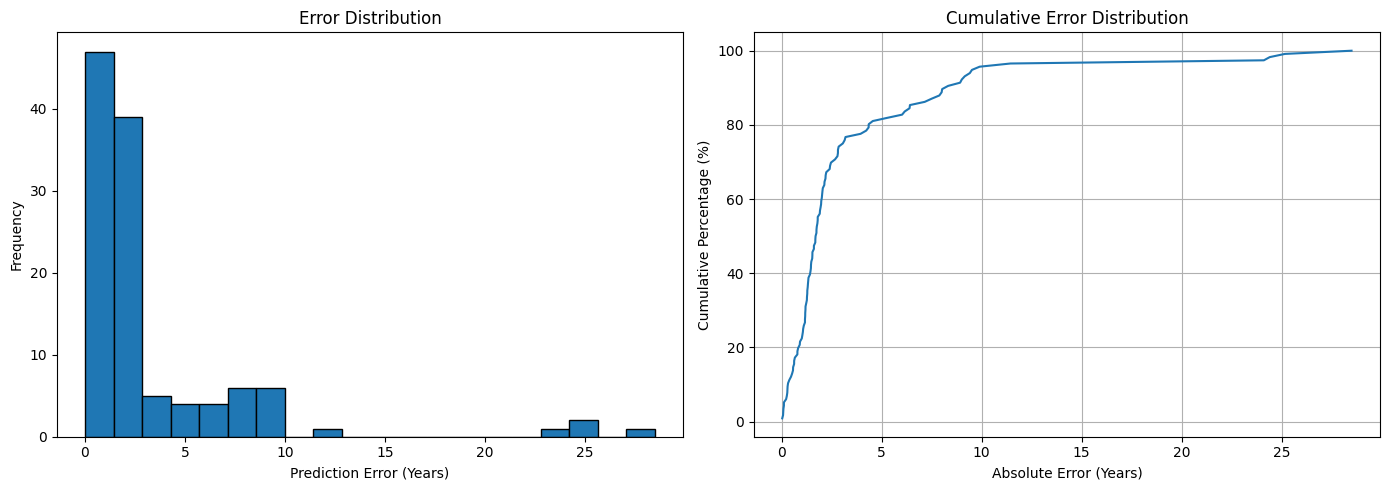

In [ ]:
# Generate predictions with image IDs
ensemble_predictions_with_ids = ensemble_predict(trained_models, test_dataset)

# Group prediction by image
predicted_images, true_images = group_predictions_by_image_id(ensemble_predictions_with_ids, labels_data)

# Compute metrics
evaluation_metrics = compute_evaluation_metrics(true_images, predicted_images)

### Individual Model Metrics


Evaluating ResNet50...
MAE: 3.15
RMSE: 5.87
R2: 0.14
MAPE: 17.68
Within ±2 Years (%): 63.79
Within ±5 Years (%): 79.31
Within ±10 Years (%): 96.55
Max Error: 29.82
Median Error: 1.48
Cumulative Error ≤ 5 Years (%): 79.31


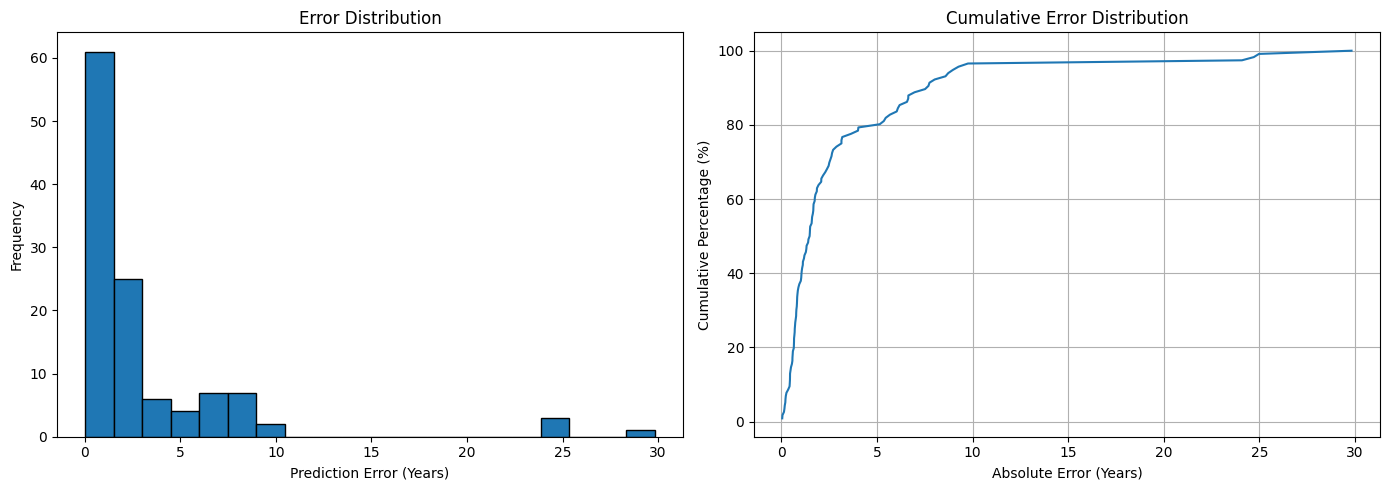





Evaluating InceptionV3...
MAE: 3.71
RMSE: 6.23
R2: 0.03
MAPE: 21.78
Within ±2 Years (%): 46.55
Within ±5 Years (%): 80.17
Within ±10 Years (%): 91.38
Max Error: 27.18
Median Error: 2.07
Cumulative Error ≤ 5 Years (%): 80.17


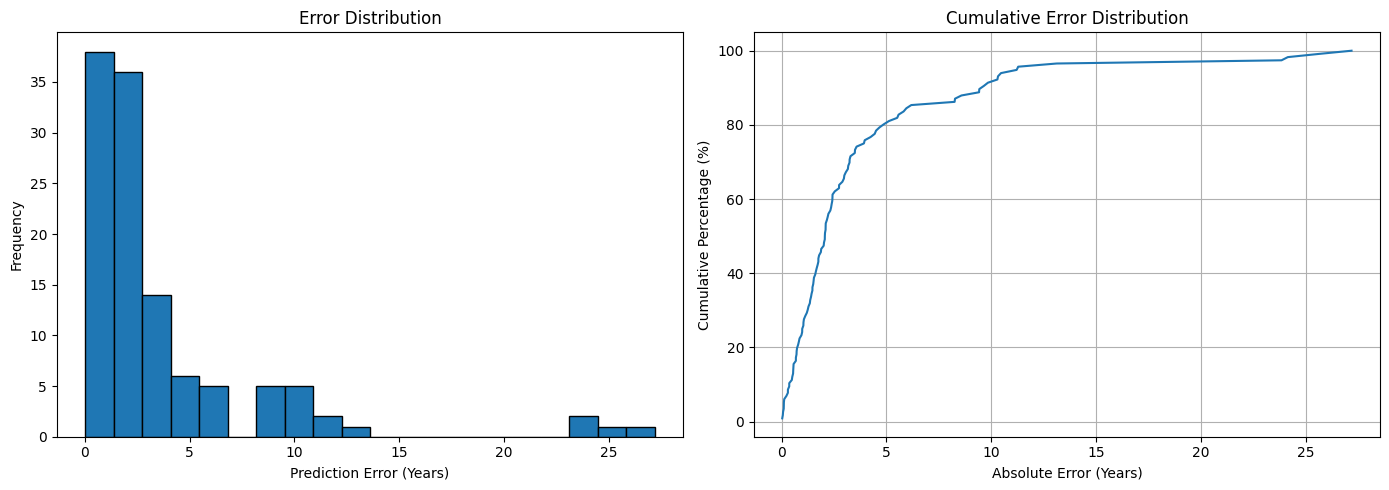





Evaluating InceptionResNetV2...
MAE: 4.97
RMSE: 6.60
R2: -0.09
MAPE: 30.62
Within ±2 Years (%): 12.07
Within ±5 Years (%): 68.10
Within ±10 Years (%): 94.83
Max Error: 27.10
Median Error: 3.64
Cumulative Error ≤ 5 Years (%): 68.10


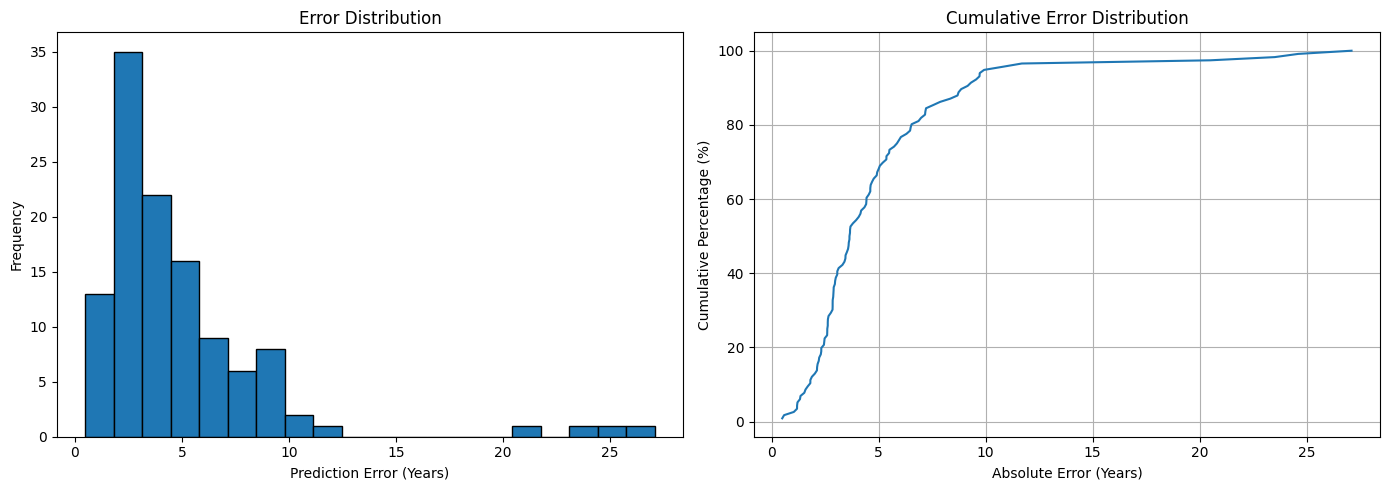





Evaluating DenseNet121...
MAE: 4.58
RMSE: 6.59
R2: -0.08
MAPE: 27.18
Within ±2 Years (%): 14.66
Within ±5 Years (%): 72.41
Within ±10 Years (%): 96.55
Max Error: 30.21
Median Error: 3.31
Cumulative Error ≤ 5 Years (%): 72.41


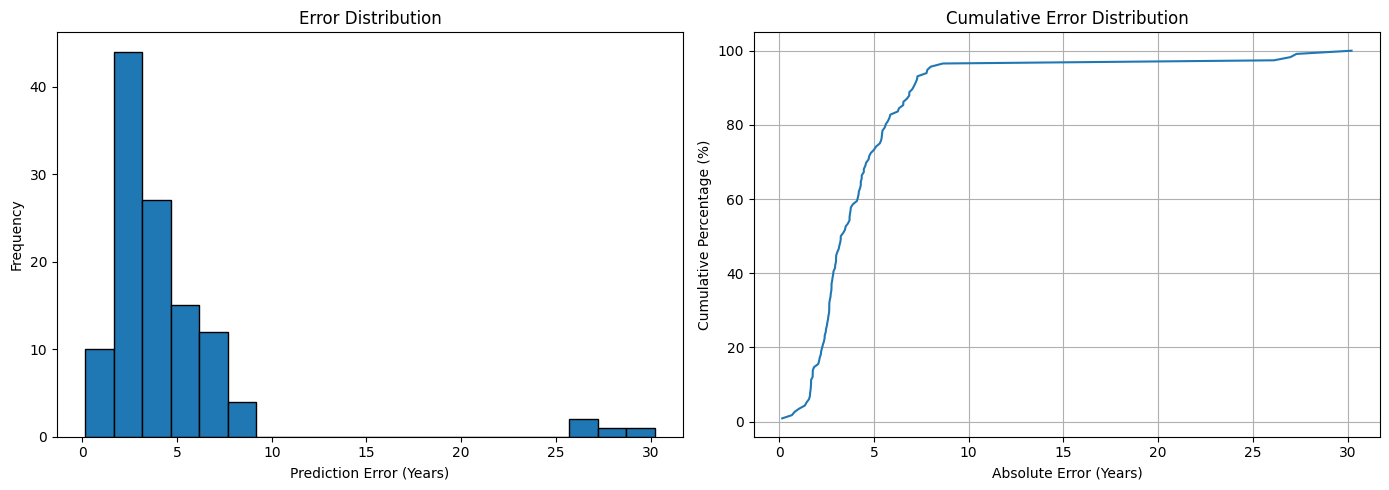





Evaluating EfficientNetV2M...
MAE: 6.92
RMSE: 8.02
R2: -0.61
MAPE: 43.22
Within ±2 Years (%): 1.72
Within ±5 Years (%): 25.00
Within ±10 Years (%): 96.55
Max Error: 29.15
Median Error: 5.96
Cumulative Error ≤ 5 Years (%): 25.00


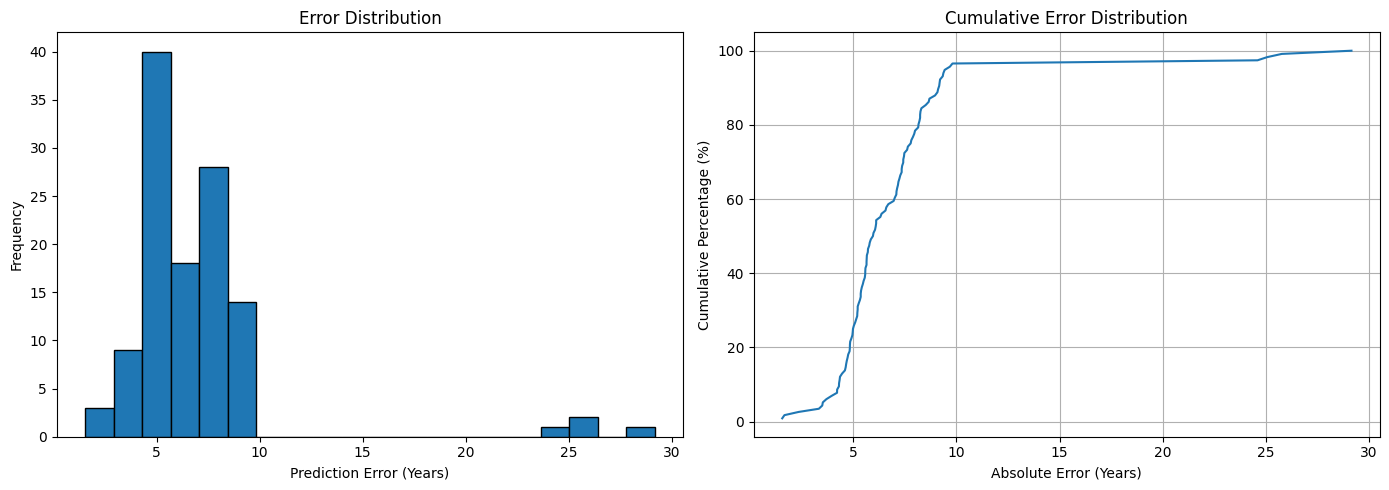

In [ ]:
for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    individual_metrics = evaluate_individual_model(model, test_dataset, labels_data)
    print("\n\n")

# Checks


In [ ]:
# Standardize the predicted image IDs
pred_ids = {os.path.basename(image_id.decode('utf-8')) for _, image_id in ensemble_predictions_with_ids}
test_labels = labels_data[labels_data['Set'] == 'test']
label_ids = set(test_labels['File'])

# Recheck mismatched IDs
missing_preds = label_ids - pred_ids
extra_preds = pred_ids - label_ids

print(f"IDs in labels but missing predictions: {missing_preds}")
print(f"Extra IDs in predictions: {extra_preds}")


IDs in labels but missing predictions: set()
Extra IDs in predictions: set()


In [ ]:
# Filter labels_data for the test set
test_labels_data = labels_data[labels_data['Set'] == 'test']

# Ensure no discrepancies in test labels
print(f"Number of test labels: {len(test_labels_data)}")
print(f"Number of unique files in test_labels_data['File']: {test_labels_data['File'].nunique()}")


Number of test labels: 116
Number of unique files in test_labels_data['File']: 116


In [ ]:
# List of files in test directory
available_files = set(os.listdir(test_dir))

# Check for missing files
missing_files = set(test_labels_data['File']) - available_files
print(f"Files in labels but missing from test directory: {missing_files}")

Files in labels but missing from test directory: set()


In [ ]:
test_labels_data = labels_data[labels_data["Set"] == "test"].copy()

# Which test-set filenames do not exist in test_dir?
missing_from_disk = []
for f in test_labels_data["File"]:
    full_path = os.path.join(test_dir, f)
    if not os.path.exists(full_path):
        missing_from_disk.append(f)

print("Files referenced in CSV but not found on disk:")
print(missing_from_disk)


Files referenced in CSV but not found on disk:
[]


In [ ]:
missing_from_disk = [f for f in test_labels_data["File"]
                     if not os.path.exists(os.path.join(test_dir, f))]
print("Missing from disk:", missing_from_disk)

Missing from disk: []


In [ ]:
# Suppose you pick some test image that is "missing"
some_file = "w78_F_1_form15.tif"
test_path = os.path.join(test_dir, some_file)

print("Test path:", test_path)
print("Exists on disk:", os.path.exists(test_path))

Test path: /content/drive/MyDrive/HHD_AgeSplit/test/w78_F_1_form15.tif
Exists on disk: False
